Milestone 1 ( Week 1-2 )

In [2]:
!pip install ultralytics
# if not installed install this

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.5/877.5 kB 15.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Paths to your local directories
Input_path = '/content/drive/MyDrive/Colab Notebooks/archive/css-data'
 # Replace with your path
Work_path = '/content/drive/MyDrive/Colab Notebooks/archive/results_yolov8n_100e/kaggle/working'
 # Replace with your path

In [6]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [7]:
# Dictionary for class index
class_idx = {str(i): classes[i] for i in range(num_classes)}

In [8]:
dict_file = {'train': os.path.join(Input_path, 'train'),
             'val': os.path.join(Input_path, 'valid'),
             'test': os.path.join(Input_path, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(Work_path, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [9]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(Input_path, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count
print(class_stat)
print(data_len)

{'train': {'Hardhat': 1314, 'Mask': 1096, 'NO-Hardhat': 1380, 'NO-Mask': 1531, 'NO-Safety Vest': 1864, 'Person': 2526, 'Safety Cone': 631, 'Safety Vest': 1319, 'machinery': 2101, 'vehicle': 744}, 'valid': {'Hardhat': 42, 'Mask': 19, 'NO-Hardhat': 37, 'NO-Mask': 44, 'NO-Safety Vest': 56, 'Person': 84, 'Safety Cone': 13, 'Safety Vest': 28, 'machinery': 26, 'vehicle': 16}, 'test': {'Hardhat': 30, 'Mask': 16, 'NO-Hardhat': 25, 'NO-Mask': 30, 'NO-Safety Vest': 36, 'Person': 59, 'Safety Cone': 8, 'Safety Vest': 22, 'machinery': 22, 'vehicle': 15}}
{'train': 2605, 'valid': 114, 'test': 82}


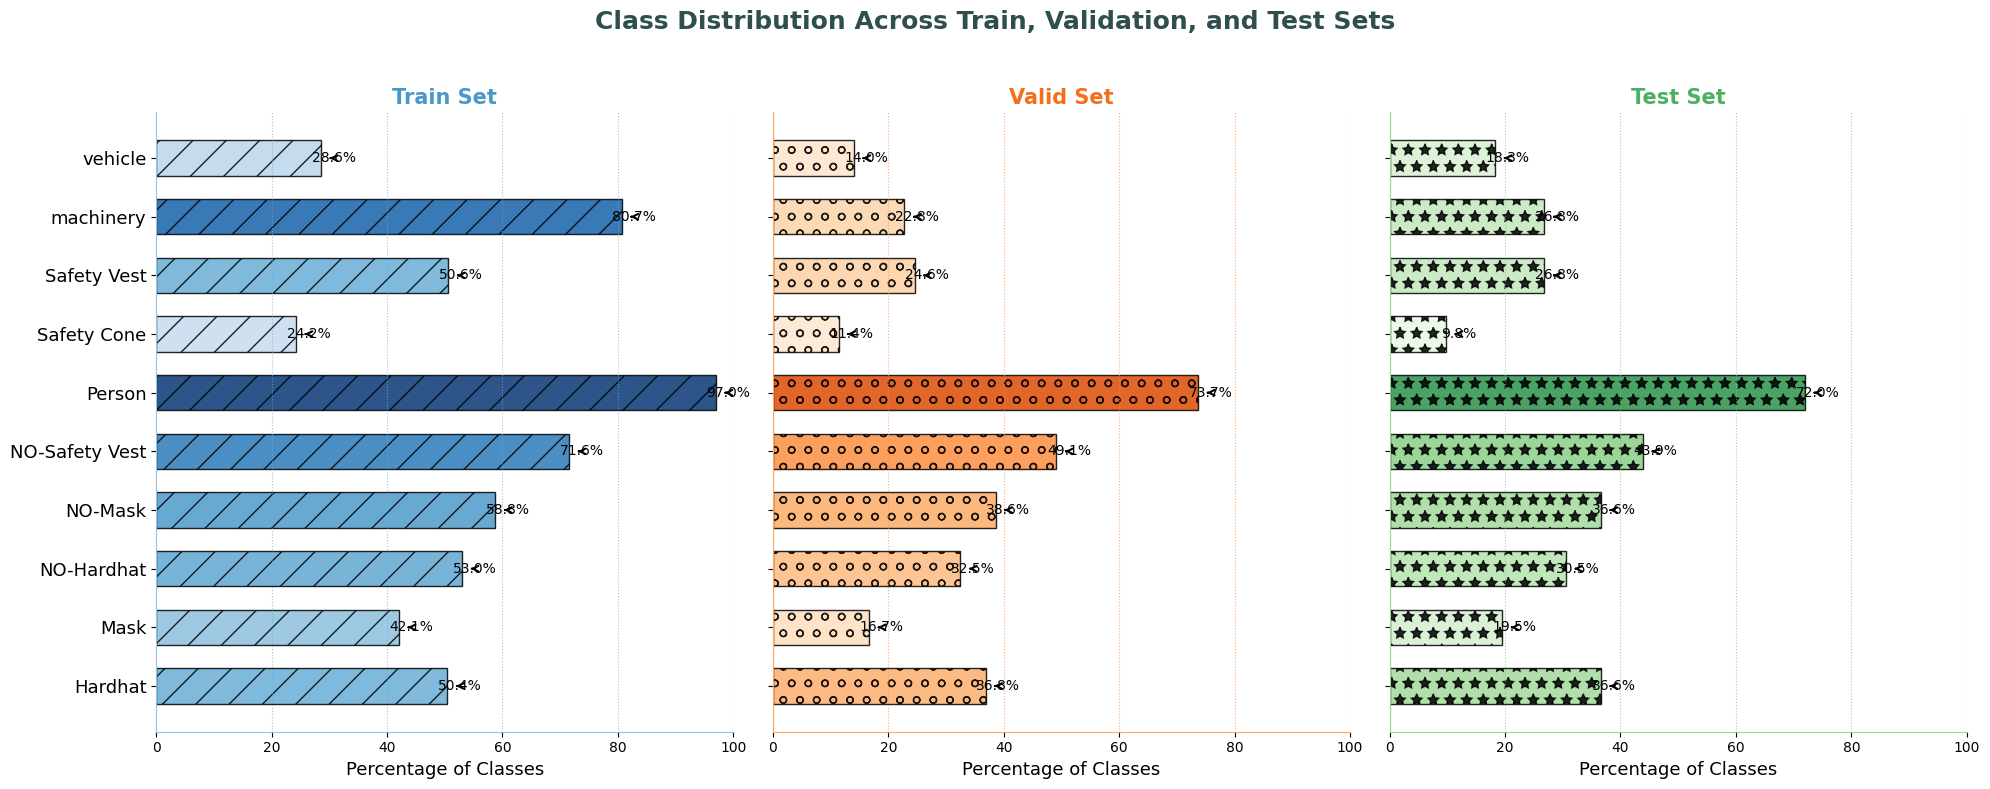

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# Gradient colors for each plot
gradient_colors = ['Blues', 'Oranges', 'Greens']

for i, mode in enumerate(['train', 'valid', 'test']):
    df = pd.DataFrame({mode: class_stat[mode]})
    df = df.T / data_len[mode] * 100
    cmap = plt.get_cmap(gradient_colors[i])

    # Create bars with gradient colors and a different bar shape (rounded)
    for idx, value in enumerate(df.loc[mode]):
        ax[i].barh(classes[idx], value, color=cmap(value / 100), edgecolor='black', alpha=0.85,
                   height=0.6, hatch='/' if i == 0 else 'o' if i == 1 else '*')

        # Add value labels on the bars with an arrow-style pointer
        ax[i].annotate(f'{value:.1f}%', xy=(value + 1, idx), xytext=(5, 0),
                       textcoords="offset points", ha='center', va='center',
                       arrowprops=dict(arrowstyle='->', lw=1.5))

    # Set plot titles and axes labels
    ax[i].set_title(f"{mode.capitalize()} Set", fontsize=15, fontweight='bold', color=cmap(0.6))
    ax[i].set_xlabel('Percentage of Classes', fontsize=13)
    ax[i].set_xlim(0, 100)
    ax[i].grid(True, axis='x', linestyle=':', color=cmap(0.5), alpha=0.7)  # Light x-axis grid
    ax[i].set_yticks(range(num_classes))
    ax[i].set_yticklabels(classes, fontsize=13)

    # Change spines' color for a unique look
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_color(cmap(0.4))
    ax[i].spines['bottom'].set_color(cmap(0.4))

# Adjust layout and add a global title
plt.suptitle("Class Distribution Across Train, Validation, and Test Sets", fontsize=18, fontweight='bold', color='darkslategray')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [11]:
# Print image sizes in each dataset
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(Input_path, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


In [12]:
# Print the number of images in each dataset
for mode in ['train', 'valid', 'test']:
    files = glob.glob(os.path.join(Input_path, mode, 'images', '*'))
    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82

